In [1]:
import os
import random
from PIL import Image
import argparse

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import pytorch_lightning as pl

In [2]:
team_id = 15
team_name = "loSSLess"
email_address = "vvb238@nyu.edu"

In [3]:
!nvidia-smi

Sat Apr 10 18:47:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:86:00.0 Off |                    0 |
| N/A   41C    P0    59W / 250W |      0MiB / 45556MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, split, transform, limit=0):
        r"""
        Args:
            root: Location of the dataset folder, usually it is /dataset
            split: The split you want to used, it should be one of train, val or unlabeled.
            transform: the transform you want to applied to the images.
        """

        self.split = split
        self.transform = transform

        self.image_dir = os.path.join(root, split)
        label_path = os.path.join(root, f"{split}_label_tensor.pt")

        if limit == 0:
            self.num_images = len(os.listdir(self.image_dir))
        else:
            self.num_images = limit

        if os.path.exists(label_path):
            self.labels = torch.load(label_path)
        else:
            self.labels = -1 * torch.ones(self.num_images, dtype=torch.long)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        with open(os.path.join(self.image_dir, f"{idx}.png"), 'rb') as f:
            img = Image.open(f).convert('RGB')

        return self.transform(img), self.labels[idx]

In [12]:
class TinyImageNetDataModule(pl.LightningDataModule):
  
    def train_dataloader(self):
        train_transform = transforms.Compose([
#             transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        trainset = CustomDataset(root='/dataset', split="train", transform=train_transform)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
        return train_loader
    
    def unlabeled_dataloader(self):
        eval_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        unlabeledset = CustomDataset(root='/dataset', split="unlabeled", transform=val_transform)
        unlabeled_loader = torch.utils.data.DataLoader(evalset, batch_size=128, shuffle=False, num_workers=4)
        return unlabeled_loader


    def val_dataloader(self):
        eval_transform = transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        evalset = CustomDataset(root='/dataset', split="val", transform=eval_transform)
        eval_loader = torch.utils.data.DataLoader(evalset, batch_size=128, shuffle=False, num_workers=4)
        return eval_loader

In [13]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

def show_image(img, title=None):
  plt.imshow(img.detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

# show_normalized_image(trainset[11][0])

In [14]:
from pl_bolts.models.autoencoders import VAE

In [19]:
data = TinyImageNetDataModule()
model = VAE(input_height=96, hidden_dim=512)

In [20]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(monitor='val_loss')

In [21]:
trainer = pl.Trainer(gpus=1,deterministic=True, max_epochs=5, default_root_dir='/scratch/vvb238/vae', profiler="simple", 
                     callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader=data.train_dataloader(), val_dataloaders=data.val_dataloader())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)


Epoch 0:  50%|█████     | 200/400 [03:46<03:46,  1.13s/it, loss=0.0587, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 200/400 [03:47<03:47,  1.14s/it, loss=0.0515, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 200/400 [03:47<03:47,  1.14s/it, loss=0.0507, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 200/400 [03:47<03:47,  1.14s/it, loss=0.0497, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 200/400 [03:47<03:47,  1.14s/it, loss=0.0469, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 400/400 [04:56<00:00,  1.35it/s, loss=0.0469, v_num=0]




Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  1484.6         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  296.53         	|5              	|  1482.7         	|  99.873         	|
run_training_batch                 	|  1.1291         	|1000           	|  1129.1         	|  76.053         	|
optimizer_step_and_closure_0       	|  1.0685         	|1000           	|  1068.5         	|  71.973         	|
training_step_and_backward         	|  0.37953        	|1000           	|  379.53         	|  25.565         	|
model_forward                      	|  0.

1

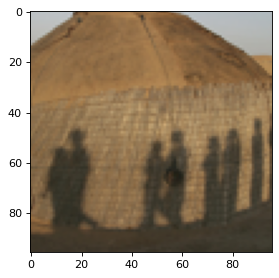

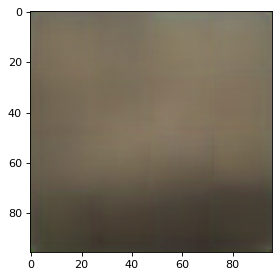

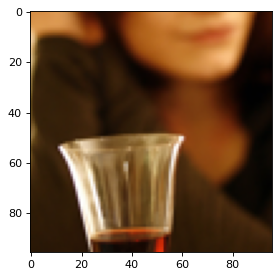

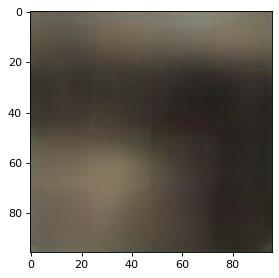

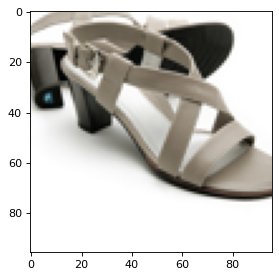

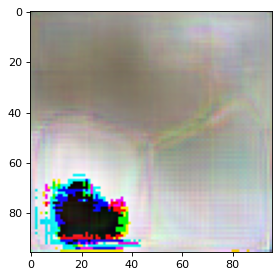

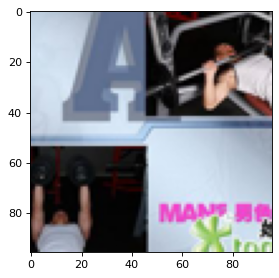

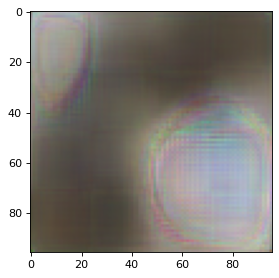

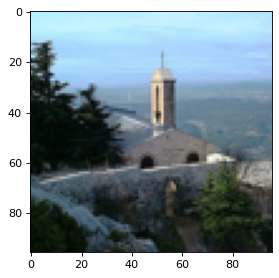

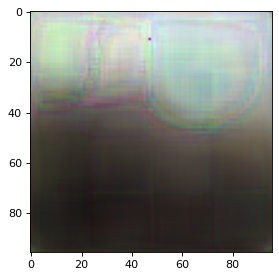

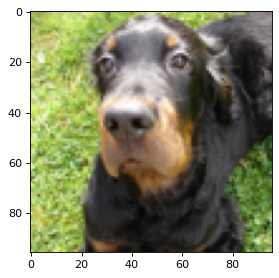

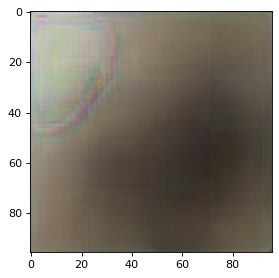

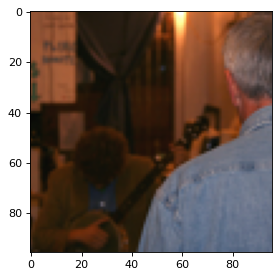

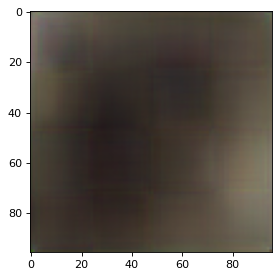

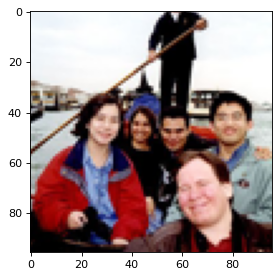

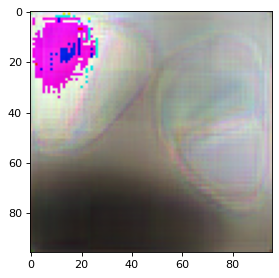

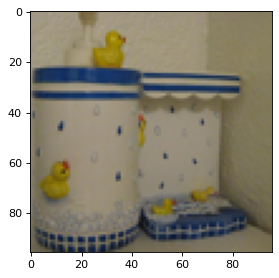

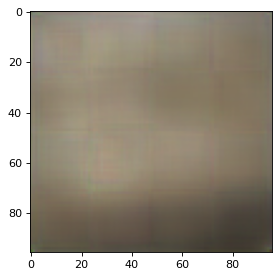

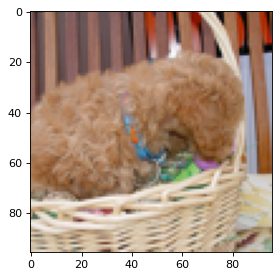

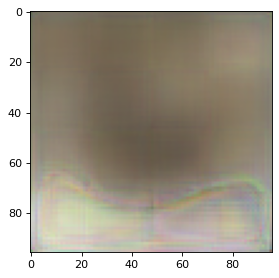

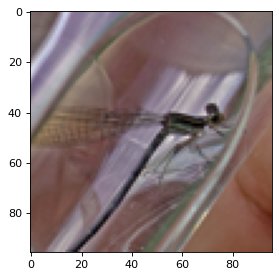

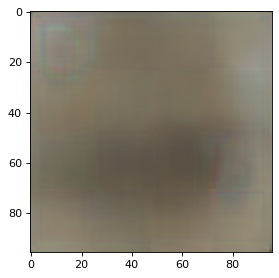

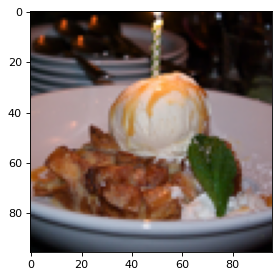

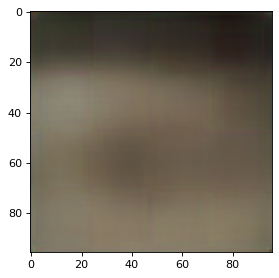

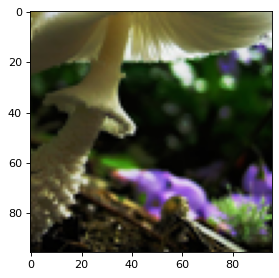

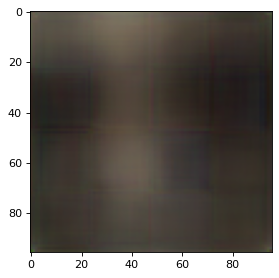

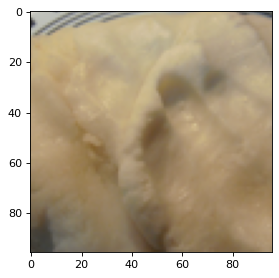

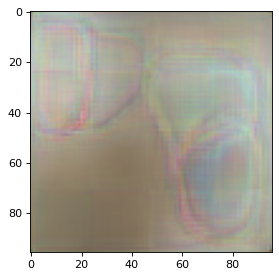

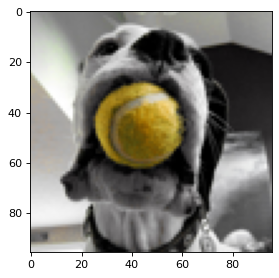

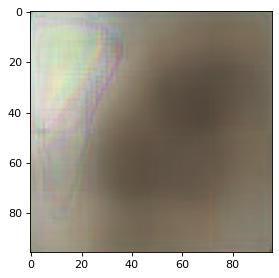

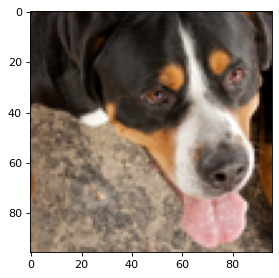

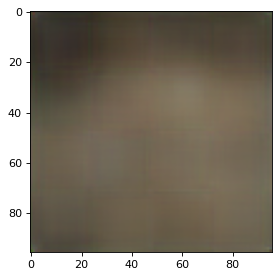

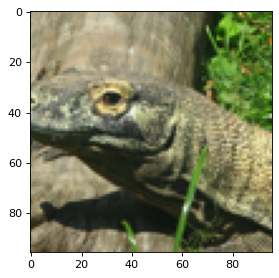

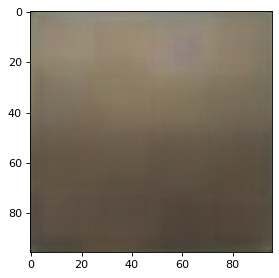

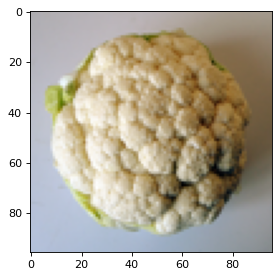

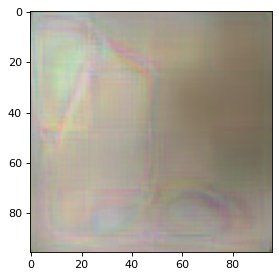

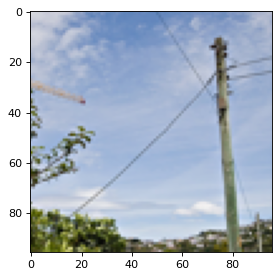

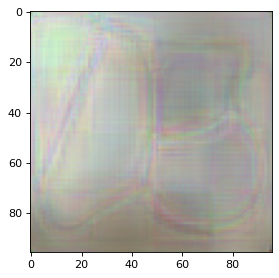

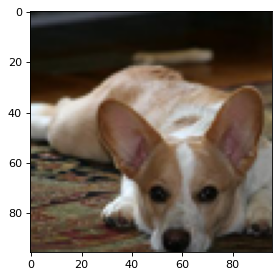

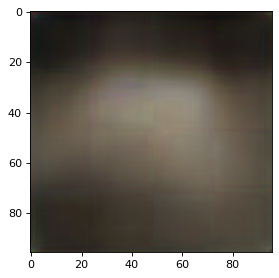

In [23]:
from PIL import Image
trans = transforms.ToPILImage()
from torchvision import transforms, utils
plt.rcParams['figure.dpi'] = 80

i = 0
cude = model.cuda()
with torch.no_grad():
    for t_img, y in data.train_dataloader():
        plt.imshow(t_img[0].permute(1, 2, 0))
        plt.show()
        t_img = t_img.cuda()
        result = cude.forward(t_img)
        result = result.cpu()
        plt.imshow(trans(result[0]))
        plt.show()
        
        
#         print(result.data[0].shape)
#         plt.imshow(  result.permute(1, 2, 0)  )
#         print(trans(result.data[0]))
#         show_normalized_image(trans(result.data[0]).cpu())
#         utils.save_image(result.data, str(i) + '.png', normalize=True)
        i += 1
        if i == 20: break